In [1]:
%cd ..
%pip install -e .

/home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
Obtaining file:///home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
  Preparing metadata (setup.py) ... done
  Attempting uninstall: src
    Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0
  Running setup.py develop for src
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random

import numpy as np
import pandas as pd

from tqdm import tqdm

from src.models.dense import NN0
from src.models.dense import NN1
from src.models.gcn import GCN1
from src.models.gcn import GCN_fix_2layer
from src.models.gat import GAT

from src.models.train_model import train_with_loss
from src.models.train_model import random_splits

from src.models.reg import make_preg_loss
from src.models.reg import make_lap_loss

from src.models.reg import make_preg_ce_ce
from src.models.reg import make_preg_ce_ce_alt
from src.models.reg import make_lap_loss_ce

from src.models.intra_class_softmax import intra_class_distance
from src.models.intra_class_softmax_alt import intra_class_distance_alt_1

from src.models.reg import compute_a_hat

from src.models.evaluate_model import evaluate0
from src.models.evaluate_model import evaluate1

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from sklearn.manifold import TSNE

from src.models.evaluate_model import test

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=T.NormalizeFeatures())
dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0].to(device)

A_hat = compute_a_hat(data)

data = random_splits(data, 70, 20)
data.reg_mask = torch.ones_like(data.train_mask, dtype=torch.bool)

In [4]:
print('-------------------------------------------------------------')
print(f'train size: {data.train_mask.sum()}')
print(f'val size: {data.val_mask.sum()}')
print(f'test size: {data.test_mask.sum()}')
print('-------------------------------------------------------------')

metrics = []
for s in tqdm(range(5)):
    for mu in range(11):
        torch.manual_seed(s)
        random.seed(s)

        mu = mu / 10
        # loss_fn = make_preg_loss(L_cls, L_preg, mu, A_hat)
        # loss_fn = make_preg_ce_ce(mu, A_hat)
        loss_fn = make_preg_ce_ce_alt(mu, A_hat)
        model = GCN1(num_node_features=dataset.num_node_features,
            num_classes=dataset.num_classes,
            hidden_channels=8) \
            .to(device)

        model = train_with_loss(model, data, loss_fn, num_epochs=200)

        acc = evaluate0(model, data)

        train_acc, val_acc, test_acc = evaluate1(model, data)
        icd = intra_class_distance_alt_1(model(data), data)
        metrics.append({'s': s, 'mu': mu, 'train_acc': np.round(train_acc,4), 'val_acc': np.round(val_acc,4), 'test_acc': np.round(test_acc,4), 'intra_class_distance': np.round(icd, 4)})
        # print(metrics[-1])

-------------------------------------------------------------
train size: 490
val size: 140
test size: 2078
-------------------------------------------------------------


100%|██████████| 5/5 [03:39<00:00, 43.92s/it]


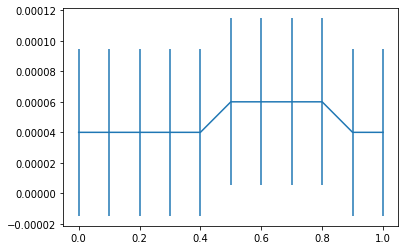

In [5]:
df = pd.DataFrame(metrics)
# df['intra_class_distance'] = df['intra_class_distance'].apply(lambda l: l.item())
means = df.groupby(['mu']).mean()['intra_class_distance']
stds = df.groupby(['mu']).std()['intra_class_distance']
mus = means.index
plt.errorbar(mus, means, yerr=stds)
plt.show()